In [2]:
import psycopg2
import pandas as pd
import numpy as np
import warnings
import google.generativeai as genai
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


In [3]:
conn = psycopg2.connect(dbname='bechdel_test', user='postgres', password='guest')
cur = conn.cursor()

cur.execute('SELECT * FROM imsdb_scripts JOIN bechdel_ratings ON imsdb_scripts.imdb_id = bechdel_ratings.imdb_id JOIN tmdb_data ON tmdb_data.imdb_id = imsdb_scripts.imdb_id;')
data = pd.DataFrame(cur.fetchall())
df = data.copy()
df.set_index(0, inplace=True)

cur.execute('SELECT genre.imdb_id, genre FROM genre JOIN imsdb_scripts ON imsdb_scripts.imdb_id = genre.imdb_id;')
genre = pd.DataFrame(cur.fetchall())
cur.close()
conn.close()

In [4]:
for genre_ in genre[1].unique():
    df[genre_] = pd.Series()

In [5]:
for row in genre.iterrows():
    df[row[1][1]][row[1][0]] = 1

In [6]:
df.rename(columns={0:'imdb_id',
                        1:'script_date',
                        2:'script',
                        3:'bechdel_id',
                        5:'title',
                        6:'release_year',
                        7:'bechdel_rating',
                        11:'language',
                        13:'popularity',
                        14:'vote_average',
                        15:'vote_count',
                        16:'overview'
                        }, 
               inplace=True)
df.drop(columns=[4, 8, 9, 10, 12], inplace=True)
df.fillna(0, inplace=True)
df.replace('none', np.nan, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['bechdel_rating']), df['bechdel_rating'], test_size=0.234, random_state=42)

In [8]:
def y_transform(y):
    y = pd.DataFrame(y)
    y['pass_fail'] = y['bechdel_rating'].map({0:0, 1:0, 2:0, 3:1})
    return y
y_train, y_test = y_transform(y_train), y_transform(y_test)

In [9]:
X_train

,script_date,script,bechdel_id,title,release_year,language,popularity,vote_average,vote_count,overview,...,Thriller,War,Comedy,Music,Western,Horror,Science Fiction,Action,Animation,History
0,,,,,,,,,,,,,,,,,,,,,
472033,NaN,\n\n ...,494,9,2009,en,71.590,6.921,3407,"When 9 first comes to life, he finds himself i...",...,1,0,0,0,0,0,1,1,1,0
120780,March 1998,"""Out of Sight""\r\n\r\n\r\n ...",2247,Out of Sight,1998,en,24.781,6.682,1203,"Meet Jack Foley, a smooth criminal who bends t...",...,0,0,1,0,0,0,0,0,0,0
1706593,NaN,CHRONICLE\r\n\r\n\r\...,3037,Chronicle,2012,en,40.036,6.816,5119,Three high school students make an incredible ...,...,1,0,0,0,0,0,1,0,0,0
2911666,NaN,JOHN WICK\r\n\r\n\...,5897,John Wick,2014,en,105.961,7.430,18679,Ex-hitman John Wick comes out of retirement to...,...,1,0,0,0,0,0,0,1,0,0
61722,March 1967,"\t\t\t\t""THE GRADUATE""\r\n\r\n\r\n\t\t\t\tScre...",616,"Graduate, The",1967,en,30.980,7.700,3206,"Benjamin, a recent college graduate very worri...",...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100814,June 1988,"\n\nS. S. Wilson & Brent Maddock's ""Tremors""\n...",1663,Tremors,1990,en,77.463,6.896,3105,Val McKee and Earl Bassett are in a fight for ...,...,0,0,1,0,0,1,1,1,0,0
109506,September 1992,The CROW\r\n\r\n\tby\r\n\r\n\tDavis Schow\r\n\...,3820,"Crow, The",1994,en,54.672,7.527,3786,Exactly one year after young rock guitarist Er...,...,1,0,0,0,0,0,0,1,0,0
765443,NaN,EASTERN PROMISES\r\...,3069,Eastern Promises,2007,en,35.119,7.362,3194,A Russian teenager living in London dies durin...,...,1,0,0,0,0,0,0,0,0,0


## Modeling without LLMs

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [11]:

param_grid = {'n_estimators': [1000],
              'max_depth': [7],
              'min_samples_split': [15],
              'min_samples_leaf': [4]}
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid,
                    cv=3)
grid.fit(X_train[['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History']], y_train['pass_fail'])
grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 1000}

In [12]:
random_forest_clf = grid.best_estimator_
y_test['pass_fail'] == random_forest_clf.predict(X_test[['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History']])

0
6644200     True
100477      True
124315     False
78748      False
480687     False
           ...  
349903      True
481499     False
905372      True
43014      False
86510       True
Name: pass_fail, Length: 100, dtype: bool

In [13]:
apikey = open('apikey.txt').read()
genai.configure(api_key=apikey)
model = 'models/embedding-001'
from google.api_core import retry
from tqdm.auto import tqdm
tqdm.pandas()

def make_embed_text_fn(model):
    @retry.Retry(timeout=300.0)
    def embed_fn(text: str) -> list[float]:
        embedding = genai.embed_content(model=model,
                                        content=text,
                                        task_type='classification')
        return embedding['embedding']
    return embed_fn

def create_embeddings(model, df):
    df['embeddings'] = df['overview'].progress_apply(make_embed_text_fn(model))
    return df


In [14]:
X_train_embedded = create_embeddings(model, X_train)

  0%|          | 0/326 [00:00<?, ?it/s]

In [15]:
X_train_embedded.head()

,script_date,script,bechdel_id,title,release_year,language,popularity,vote_average,vote_count,overview,...,War,Comedy,Music,Western,Horror,Science Fiction,Action,Animation,History,embeddings
0,,,,,,,,,,,,,,,,,,,,,
472033,NaN,\n\n ...,494,9,2009,en,71.590,6.921,3407,"When 9 first comes to life, he finds himself i...",...,0,0,0,0,0,1,1,1,0,"[0.009933546, 0.028054273, -0.027433202, 0.011..."
120780,March 1998,"""Out of Sight""\r\n\r\n\r\n ...",2247,Out of Sight,1998,en,24.781,6.682,1203,"Meet Jack Foley, a smooth criminal who bends t...",...,0,1,0,0,0,0,0,0,0,"[0.054206412, 0.025492756, 0.036431577, -0.048..."
1706593,NaN,CHRONICLE\r\n\r\n\r\...,3037,Chronicle,2012,en,40.036,6.816,5119,Three high school students make an incredible ...,...,0,0,0,0,0,1,0,0,0,"[0.0023177029, -0.011539809, -0.0100571215, 0...."
2911666,NaN,JOHN WICK\r\n\r\n\...,5897,John Wick,2014,en,105.961,7.430,18679,Ex-hitman John Wick comes out of retirement to...,...,0,0,0,0,0,0,1,0,0,"[0.048869684, 0.029862285, -0.0062307036, -0.0..."
61722,March 1967,"\t\t\t\t""THE GRADUATE""\r\n\r\n\r\n\t\t\t\tScre...",616,"Graduate, The",1967,en,30.980,7.700,3206,"Benjamin, a recent college graduate very worri...",...,0,1,0,0,0,0,0,0,0,"[0.04377451, -0.034744043, 0.011599346, -0.005..."


In [16]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

mlp_clf = MLPClassifier()


In [17]:
def emb_arr(col=X_train_embedded['embeddings']):
    embeddings = np.ndarray((len(col),768))
    j = 0
    for i in col.index:
        try:
            embeddings[j] = col[i]
            j+=1
        except: j+=1
    return embeddings

In [18]:
embeddings = emb_arr(X_train_embedded['embeddings'])

In [19]:
mlp = MLPClassifier()
mlp.fit(embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1))


MLPClassifier()

In [20]:
from sklearn.model_selection import cross_val_score, cross_val_predict

mlp = MLPClassifier()
cross_val_score(mlp, embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1), cv=5)

array([0.56060606, 0.70769231, 0.64615385, 0.64615385, 0.61538462])

In [21]:
param_grid = {
    'hidden_layer_sizes':[(32,),(50,),(64,),(32,32,)],
    'solver':['lbfgs']
}
grid = GridSearchCV(MLPClassifier(random_state=0), 
                    param_grid=param_grid,
                    cv=3
                    )
grid.fit(embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1))

grid.best_params_

{'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}

In [22]:
cross_val_score(grid.best_estimator_, embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1), cv=5)

array([0.51515152, 0.72307692, 0.64615385, 0.63076923, 0.64615385])

In [23]:
X_train_embedded['neural_net_preds'] = cross_val_predict(MLPClassifier(hidden_layer_sizes=(50,), solver='lbfgs'), embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1), cv=6)

In [24]:
cross_val_score(RandomForestClassifier(max_depth=7,
 min_samples_leaf=4,
 min_samples_split=15,
 n_estimators=1000), X_train_embedded[['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History', 'neural_net_preds']], y_train['pass_fail'])

array([0.54545455, 0.70769231, 0.73846154, 0.58461538, 0.63076923])

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = GridSearchCV(DecisionTreeClassifier(),
                        param_grid={'max_depth': [1,2,3,4,5],
                                    'min_samples_leaf': [1,2,3,4,5,40,50],
                                    'min_samples_split': [2,3,4,40,50],
                                    'max_features': [1,2,3,12,30]},
                        cv=10)
tree_clf.fit(X_train_embedded[['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History', 'neural_net_preds']], y_train['pass_fail'])
tree_clf.best_params_

{'max_depth': 3,
 'max_features': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 50}

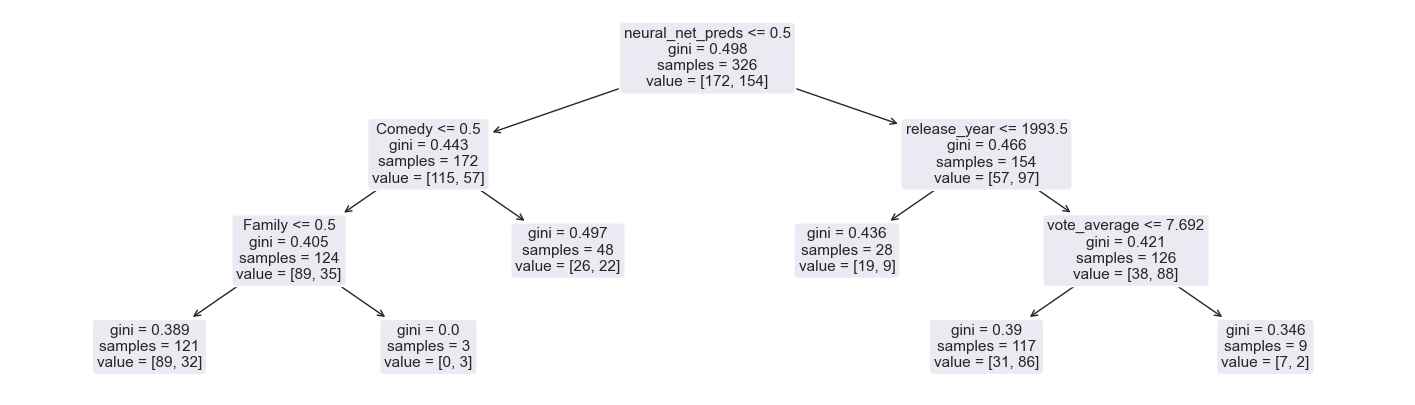

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,5))
plot_tree(tree_clf.best_estimator_, fontsize=11, feature_names=['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History', 'neural_net_preds'], ax=ax, rounded=True)
plt.show()

In [27]:
X_test_embedded = create_embeddings(model, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
test_embeddings = emb_arr(col=X_test_embedded['embeddings'])
mlp_trained = MLPClassifier(hidden_layer_sizes=(50,),solver='lbfgs')
mlp_trained.fit(embeddings, y_train['pass_fail'].reset_index().drop(0, axis=1))
X_test_embedded['neural_net_preds'] = mlp_trained.predict(test_embeddings)
test_preds = tree_clf.best_estimator_.predict(X_test_embedded[['release_year', 'popularity', 'vote_average', 'vote_count', 'Drama', 'Romance', 'Adventure', 'Animation', 'Fantasy', 'Science Fiction', 'Family', 'Mystery', 'Crime', 'Thriller', 'War', 'Western', 'Comedy', 'Music', 'Horror', 'Action', 'History', 'neural_net_preds']])

In [29]:
X_test_embedded['neural_net_preds'] == y_test['pass_fail']

0
6644200     True
100477     False
124315      True
78748       True
480687     False
           ...  
349903      True
481499      True
905372      True
43014       True
86510       True
Length: 100, dtype: bool

In [30]:
test_preds == y_test['pass_fail']

0
6644200     True
100477      True
124315      True
78748      False
480687     False
           ...  
349903      True
481499      True
905372      True
43014      False
86510       True
Name: pass_fail, Length: 100, dtype: bool

In [31]:
X_train_embedded['neural_net_preds'] == y_train['pass_fail']

0
472033      True
120780      True
1706593    False
2911666     True
61722      False
           ...  
100814      True
109506     False
765443      True
816462      True
110148      True
Length: 326, dtype: bool

In [32]:
conn = psycopg2.connect(dbname='bechdel_test', user='postgres', password='guest')
cur = conn.cursor()

cur.execute('SELECT * FROM bechdel_ratings JOIN tmdb_data ON tmdb_data.imdb_id = bechdel_ratings.imdb_id;')
data = pd.DataFrame(cur.fetchall())
df = data.copy()
df.set_index(0, inplace=True)
cur.close()
conn.close()

In [33]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,,,,,,,,,,,,,
9804,14495706,La Rosace Magique,1877,0,766094,14495706,The Magic Rosette,xx,1878-05-07,2.194,5.800,19,Praxinoscope strip of a shifting rosette. Seri...
9806,12592084,Le singe musicien,1878,0,751212,12592084,The Musician Monkey,xx,1878-05-07,2.560,5.900,25,A pre-cinematograph colour animation of the mo...
9832,8588366,L&#39;homme machine,1885,0,585297,8588366,L'Homme Machine,xx,1885-01-01,1.149,4.629,31,Animated stick drawings representing a man wal...
9614,2075247,Man Walking Around the Corner,1887,0,159897,2075247,Man Walking Around a Corner,xx,1887-08-18,5.529,4.900,80,The last remaining production of Le Prince's L...
9841,7754902,Man Riding Jumping Horse,1887,0,1191584,7754902,Man Riding Jumping Horse,en,None,0.187,4.000,5,A man riding a horse jumps over an obstacle.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,21235248,Ghostbusters: Frozen Empire,2024,3,967847,21235248,Ghostbusters: Frozen Empire,en,2024-03-20,603.739,6.671,873,When the discovery of an ancient artifact unle...
11303,3359350,Road House,2024,3,359410,3359350,Road House,en,2024-03-08,483.627,7.024,1810,Ex-UFC fighter Dalton takes a job as a bouncer...
11317,14539740,Godzilla x Kong: New Empire,2024,3,823464,14539740,Godzilla x Kong: The New Empire,en,2024-03-27,3853.790,7.278,2211,"Following their explosive showdown, Godzilla a..."


In [48]:
model = genai.GenerativeModel('gemini-1.5-flash', safety_settings=[
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_NONE"
  },
])
import time
timer = time.time()
gemini_flash_guesses = []

for i in X_train.index[:10]:
    chat = model.start_chat()
    if (1 - float(time.time() - timer)) > 0: 
        time.sleep(1 - float(time.time() - timer))
    timer = time.time()
    try: 
        response = model.generate_content('How many female characters does the following script contain?'
                                 'Script:'
                                 ''
                                 '' + X_train['script'][i] )
        r_text = response.text
    except Exception as e: 
        r_text = response.prompt_feedback
    gemini_flash_guesses.append((i, r_text))

In [49]:
gemini_flash_guesses

[(472033,
  'This script features **one** named female character: **7**. \n\nWhile the scientist is referred to as "he" and is presumably male, there are no other female characters mentioned in the script. \n'),
 (120780,
  'The script "Out of Sight" contains the following female characters:\n\n* **Loretta:** A bank teller who is robbed by Foley.\n* **Lulu:** Chino\'s "wife" and accomplice in his escape plan. \n* **Adele:** Foley\'s ex-wife.\n* **Karen Sisco:** A federal marshal who becomes involved in Foley\'s escape and later attempts to apprehend him.\n* **Moselle:** Maurice Miller\'s girlfriend.\n* **Midge:** Richard Ripley\'s maid. \n* **Yonelle:** A transsexual who is murdered at Eddie Solomon\'s house. \n* **Regina Mary Bragg:** Buddy\'s sister, a born-again Christian who calls the FBI to report Buddy and Foley.\n* **Celeste:** A waitress at the Westin Hotel in Detroit.\n\nIt\'s important to note that some of these characters are only briefly mentioned and do not have any lines 

In [47]:
X_train.loc[88944]

script_date                                                April 1985
script                                                            NaN
bechdel_id                                                       2576
title                                                        Commando
release_year                                                     1985
language                                                           en
popularity                                                     46.667
vote_average                                                    6.678
vote_count                                                       2677
overview            John Matrix, the former leader of a special co...
Drama                                                               0
Romance                                                             0
Adventure                                                           1
Fantasy                                                             0
Family              

In [111]:
response

<coroutine object ChatSession.send_message_async at 0x000001734E1BA480>

In [114]:
response.close()

In [117]:
r

AttributeError: 'coroutine' object has no attribute '__dict__'